In [1]:
#After installing, we need to call the package to make it available to R
library(readr)
if (!require(stargazer)) install.packages("stargazer")
library(stargazer)
if (!require(knitr)) install.packages("knitr")
library(knitr)
if (!require(dplyr)) install.packages("dplyr")
library(dplyr)
#library(GGally)
#library("psych")
library(ggplot2)
if (!require(stringr)) install.packages("stringr")
library(stringr)
if (!require(ggExtra)) install.packages("ggExtra")
library(ggExtra)
if (!require(psych)) install.packages("psych")
library(psych)

Loading required package: stargazer

Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 

Loading required package: knitr
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: stringr
Loading required package: ggExtra
Loading required package: psych

Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



In [2]:
load("la_listing_full.RData")


In [3]:
la_listing <- la_listing_full  %>% 
                select(price,number_of_reviews,beds,bathrooms,accommodates,reviews_per_month, property_type, room_type,review_scores_rating) %>% 
                rename(Reviews = number_of_reviews) %>% 
                rename(Beds = beds) %>% 
                rename(Baths = bathrooms) %>% 
                rename(Capacity = accommodates) %>% 
                rename(Monthly_Reviews = reviews_per_month) %>% 
                rename(Property_Type = property_type) %>% 
                rename(Room_Type = room_type) %>% 
                rename(Price = price) %>% 
                rename(Rating = review_scores_rating)



In [4]:
la_listing <-  la_listing %>% 
                mutate(Price = str_replace(Price, "[$]", "")) %>% 
                mutate(Price = str_replace(Price, "[,]", "")) %>% 
                mutate(Price = as.numeric(Price)) %>% 
                mutate(Room_Type = factor(Room_Type, levels = c("Shared room", "Private room", "Entire home/apt"))) %>% 
                mutate(Capacity_Sqr = Capacity * Capacity) %>% 
                mutate(Beds_Sqr = Beds * Beds) %>% 
                mutate(Baths_Sqr = Baths * Baths) %>% 
                mutate(ln_Price = log(1+Price)) %>% 
                mutate(ln_Beds = log(1+Beds)) %>%
                mutate(ln_Baths = log(1+Baths)) %>% 
                mutate(ln_Capacity = log(1+Capacity)) %>% 
                mutate(ln_Rating = log(1+Rating)) %>% 
                mutate(Shared_ind = ifelse(Room_Type == "Shared room",1,0)) %>% 
                mutate(House_ind = ifelse(Room_Type == "Entire home/apt",1,0)) %>% 
                mutate(Private_ind = ifelse(Room_Type == "Private room",1,0)) %>% 
                mutate(Capacity_x_Shared_ind = Shared_ind * Capacity) %>% 
                mutate(H_Cap = House_ind * Capacity) %>% 
                mutate(P_Cap = Private_ind * Capacity) %>% 
                mutate(ln_Capacity_x_Shared_ind = Shared_ind * ln_Capacity) %>% 
                mutate(ln_Capacity_x_House_ind = House_ind * ln_Capacity) %>% 
                mutate(ln_Capacity_x_Private_ind = Private_ind * ln_Capacity)


In [5]:
la_listing <- la_listing %>% 
              dplyr::filter(Price < 1000 , !is.na(Beds), !is.na(Baths), !is.na(Price), !is.na(Rating)) %>% 
                dplyr::filter(Capacity < 9) %>% 
                mutate(ln_Reviews = log(1+Reviews)) %>% 
                mutate(ln_Monthly_Reviews = log(1+Monthly_Reviews))


In [6]:
#We can examine if the number of people a listing can accomodate is related to price. 

lm0 <- lm(Price ~ Capacity, data = la_listing)
summary(lm0)
stargazer(lm0, type = "text")



Call:
lm(formula = Price ~ Capacity, data = la_listing)

Residuals:
    Min      1Q  Median      3Q     Max 
-275.21  -38.58  -11.13   22.42  812.42 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  15.0389     1.1405   13.19   <2e-16 ***
Capacity     36.2719     0.3162  114.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 83.41 on 22725 degrees of freedom
Multiple R-squared:  0.3668,	Adjusted R-squared:  0.3667 
F-statistic: 1.316e+04 on 1 and 22725 DF,  p-value: < 2.2e-16



                         Dependent variable:     
                    -----------------------------
                                Price            
-------------------------------------------------
Capacity                      36.272***          
                               (0.316)           
                                                 
Constant                      15.039***          
                               (1.141)           
                                                 
-------------------------------------------------
Observations                   22,727            
R2                              0.367            
Adjusted R2                     0.367            
Residual Std. Error      83.410 (df = 22725)     
F Statistic         13,161.880*** (df = 1; 22725)
Note:                 *p<0.1; **p<0.05; ***p<0.01


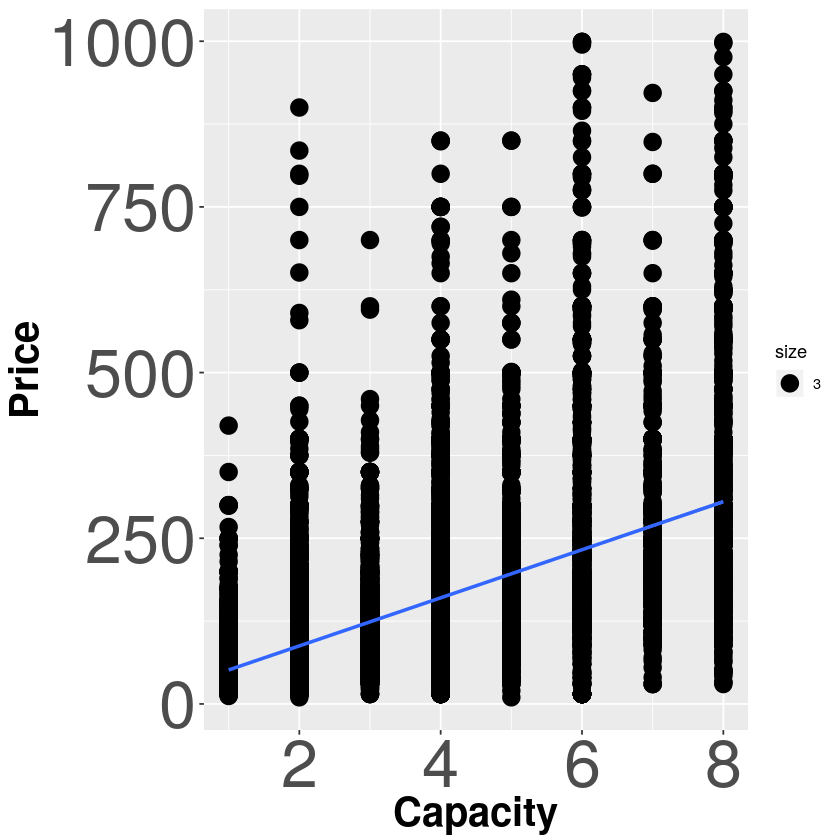

In [7]:
ggplot(data = la_listing, aes(x = Capacity, y = Price)) + geom_point(aes(size=3)) +
scale_colour_hue(l=50) + # Use a slightly darker palette than normal
geom_smooth(method=lm,   # Add linear regression lines
           se=TRUE,    #  add shaded confidence region
           fullrange=TRUE) +
theme(axis.text.x = element_text(size=40), axis.text.y = element_text(size=40), 
        axis.title=element_text(size=24,face="bold"))



In [8]:
#The moderating effect of type of room. Lets model that.

lm1 <- lm(Price ~ Private_ind + House_ind, data = la_listing)
summary(lm1)
stargazer(lm1, type = "text")




Call:
lm(formula = Price ~ Private_ind + House_ind, data = la_listing)

Residuals:
    Min      1Q  Median      3Q     Max 
-160.59  -45.59  -15.59   17.19  828.41 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   37.149      2.954   12.58   <2e-16 ***
Private_ind   35.666      3.123   11.42   <2e-16 ***
House_ind    133.442      3.058   43.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 91.95 on 22724 degrees of freedom
Multiple R-squared:  0.2306,	Adjusted R-squared:  0.2305 
F-statistic:  3404 on 2 and 22724 DF,  p-value: < 2.2e-16



                        Dependent variable:     
                    ----------------------------
                               Price            
------------------------------------------------
Private_ind                  35.666***          
                              (3.123)           
                                                
House_ind                    133.442***         
                              (3.058)           
                                                
Constant                     37.149***          
                              (2.954)           
                                                
------------------------------------------------
Observations                   22,727           
R2                             0.231            
Adjusted R2                    0.230            
Residual Std. Error     91.946 (df = 22724)     
F Statistic         3,404.486*** (df = 2; 22724)
Note:                *p<0.1; **p<0.05; ***p<0.01


In [9]:
#Regression with Capacity and Dummy Variables for type of room:

lm2 <- lm(Price ~ Capacity + Private_ind + House_ind, data = la_listing)
summary(lm2)
stargazer(lm2, type = "text")




Call:
lm(formula = Price ~ Capacity + Private_ind + House_ind, data = la_listing)

Residuals:
    Min      1Q  Median      3Q     Max 
-246.09  -38.93   -9.63   20.09  784.66 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -19.0171     2.6781  -7.101 1.28e-12 ***
Capacity     29.2920     0.3546  82.605  < 2e-16 ***
Private_ind  30.3393     2.7392  11.076  < 2e-16 ***
House_ind    75.7760     2.7710  27.346  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 80.63 on 22723 degrees of freedom
Multiple R-squared:  0.4083,	Adjusted R-squared:  0.4082 
F-statistic:  5226 on 3 and 22723 DF,  p-value: < 2.2e-16



                        Dependent variable:     
                    ----------------------------
                               Price            
------------------------------------------------
Capacity                     29.292***          
                              (0.355)           
                                                
Private_ind                  30.339***          
                              (2.739)           
                                                
House_ind                    75.776***          
                              (2.771)           
                                                
Constant                     -19.017***         
                              (2.678)           
                                                
------------------------------------------------
Observations                   22,727           
R2                             0.408            
Adjusted R2                    0.408            
Residual Std. Error

In [11]:
#Regression with Capacity,Dummy Variables and interaction between the two:
lm3 <- lm(Price ~ Capacity+Private_ind + House_ind+P_Cap+H_Cap, data = la_listing)
summary(lm3)
stargazer(lm3,type = "text")



Call:
lm(formula = Price ~ Capacity + Private_ind + House_ind + P_Cap + 
    H_Cap, data = la_listing)

Residuals:
    Min      1Q  Median      3Q     Max 
-265.77  -33.32   -9.54   17.95  793.68 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  35.8849     4.1114   8.728  < 2e-16 ***
Capacity      0.6591     1.6866   0.391 0.695980    
Private_ind  20.6838     4.6722   4.427  9.6e-06 ***
House_ind     2.2931     4.4231   0.518 0.604147    
P_Cap         7.0796     1.9469   3.636 0.000277 ***
H_Cap        33.4143     1.7292  19.323  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 79.03 on 22721 degrees of freedom
Multiple R-squared:  0.4317,	Adjusted R-squared:  0.4316 
F-statistic:  3452 on 5 and 22721 DF,  p-value: < 2.2e-16



                        Dependent variable:     
                    ----------------------------
                               Price            
------------------------------------------------
Capacity                       0.659            
                              (1.687)           
                                                
Private_ind                  20.684***          
                              (4.672)           
                                                
House_ind                      2.293            
                              (4.423)           
                                                
P_Cap                         7.080***          
                              (1.947)           
                                                
H_Cap                        33.414***          
                              (1.729)           
                                                
Constant                     35.885***          
                   